# Additional Text Features

In [201]:
import pandas as pd 
import numpy as np
import nltk
from nltk.lm import Laplace
from nltk.util import ngrams
from scipy.stats import variation
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.sparse import save_npz, load_npz
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from xgboost import XGBClassifier


SEED = 2608
EXPERIMENT = 'burstiness'

In [159]:
data1 = []
with open('../data/raw/domain1_train_data.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))
data1 = pd.DataFrame(data1)

data2 = []
with open('../data/raw/domain2_train_data.json', 'r') as f:
    for line in f:
        data2.append(json.loads(line))
data2 = pd.DataFrame(data2)

data_test = []
with open('../data/raw/test_data.json', 'r') as f:
    for line in f:
        data_test.append(json.loads(line))
data_test = pd.DataFrame(data_test)


In [160]:
def calculate_perplexity(tokens):
    text = ' '.join(map(str, tokens))
    words = nltk.word_tokenize(text)
    n = len(words)
    
    # Create vocabulary
    vocab = set(words)
    
    # Generate training data
    train_data = [ngrams(words, i+1) for i in range(3)]
    
    # Fit the model with Laplace smoothing
    model = Laplace(3)
    model.fit(train_data, vocabulary_text=vocab)
    
    # Generate test data
    test_data = list(ngrams(words, n))
    
    # Compute perplexity
    perplexity = model.perplexity(test_data)
    
    return perplexity

def calculate_burstiness(tokens):
    freq_dist = pd.Series(tokens).value_counts()
    burstiness = variation(freq_dist)
    return burstiness

In [161]:
data1['perplexity'] = data1['text'].apply(calculate_perplexity)
data1['burstiness'] = data1['text'].apply(calculate_burstiness)
data1['length'] = data1['text'].apply(len)

data2['perplexity'] = data2['text'].apply(calculate_perplexity)
data2['burstiness'] = data2['text'].apply(calculate_burstiness)
data2['length'] = data2['text'].apply(len)

data_test['perplexity'] = data_test['text'].apply(calculate_perplexity)
data_test['burstiness'] = data_test['text'].apply(calculate_burstiness)
data_test['length'] = data_test['text'].apply(len)


In [232]:
# save the new dataframes 
data1.to_csv("../data/curated/data1_additional.csv")
data2.to_csv("../data/curated/data2_additional.csv")
data_test.to_csv("../data/curated/data_test_additional.csv")

---
## Visualization

In [162]:
data_whole = pd.concat([data1, data2], axis=0)

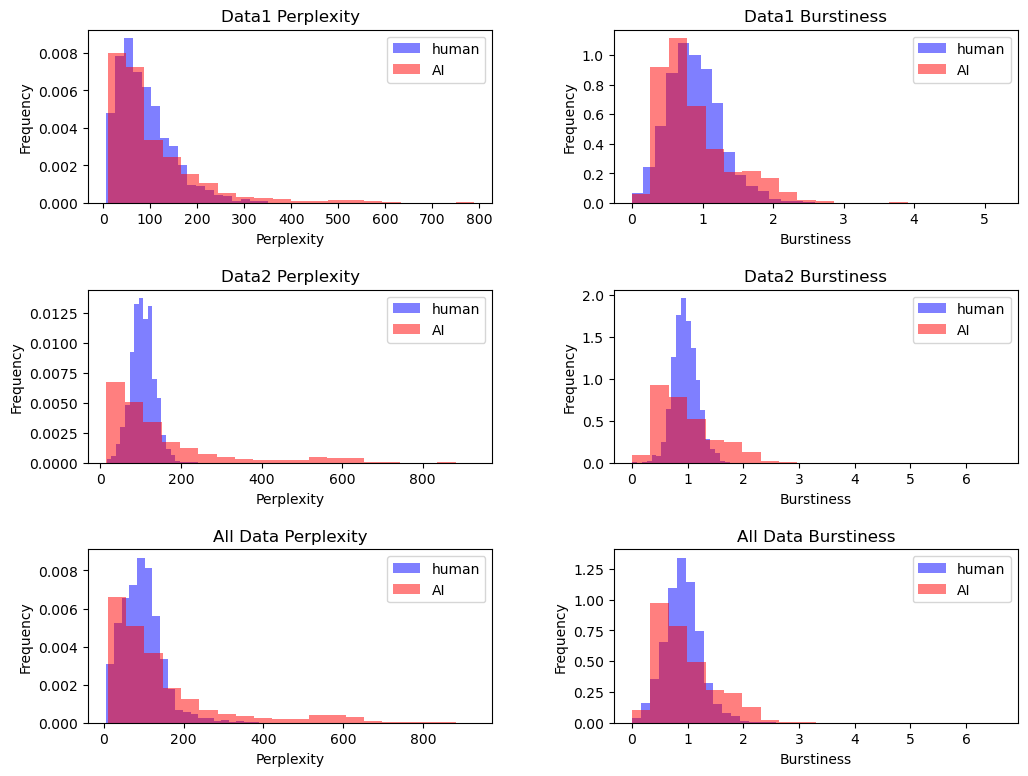

In [163]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))

axs[0][0].hist(data1[data1['label'] == 1]['perplexity'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[0][0].hist(data1[data1['label'] == 0]['perplexity'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[0][0].set_title('Data1 Perplexity')
axs[0][0].set_xlabel('Perplexity')
axs[0][0].set_ylabel('Frequency')
axs[0][0].legend()

axs[0][1].hist(data1[data1['label'] == 1]['burstiness'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[0][1].hist(data1[data1['label'] == 0]['burstiness'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[0][1].set_title('Data1 Burstiness')
axs[0][1].set_xlabel('Burstiness')
axs[0][1].set_ylabel('Frequency')
axs[0][1].legend()

axs[1][0].hist(data2[data2['label'] == 1]['perplexity'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[1][0].hist(data2[data2['label'] == 0]['perplexity'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[1][0].set_title('Data2 Perplexity')
axs[1][0].set_xlabel('Perplexity')
axs[1][0].set_ylabel('Frequency')
axs[1][0].legend()

axs[1][1].hist(data2[data2['label'] == 1]['burstiness'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[1][1].hist(data2[data2['label'] == 0]['burstiness'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[1][1].set_title('Data2 Burstiness')
axs[1][1].set_xlabel('Burstiness')
axs[1][1].set_ylabel('Frequency')
axs[1][1].legend()

axs[2][0].hist(data_whole[data_whole['label'] == 1]['perplexity'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[2][0].hist(data_whole[data_whole['label'] == 0]['perplexity'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[2][0].set_title('All Data Perplexity')
axs[2][0].set_xlabel('Perplexity')
axs[2][0].set_ylabel('Frequency')
axs[2][0].legend()

axs[2][1].hist(data_whole[data_whole['label'] == 1]['burstiness'], bins=20, color=['blue'], label=['human'], alpha=0.5, density = True)
axs[2][1].hist(data_whole[data_whole['label'] == 0]['burstiness'], bins=20, color=['red'], label=['AI'], alpha=0.5, density = True)
axs[2][1].set_title('All Data Burstiness')
axs[2][1].set_xlabel('Burstiness')
axs[2][1].set_ylabel('Frequency')
axs[2][1].legend()

plt.subplots_adjust(hspace=0.5, wspace=0.3)

---
## Data processing

In [295]:
# train-validation-test split

data1['domain'] = 1
data2['domain'] = 2

train_data1_X, test_data1_X, train_data1_y, test_data1_y = train_test_split(data1.drop('label', axis=1), data1['label'], test_size=0.3, random_state=SEED)
train_data2_X, test_data2_X, train_data2_y, test_data2_y = train_test_split(data2.drop('label', axis=1), data2['label'], test_size=0.3, random_state=SEED)
val_data1_X, test_data1_X, val_data1_y, test_data1_y = train_test_split(test_data1_X, test_data1_y, test_size=0.5, random_state=SEED)
val_data2_X, test_data2_X, val_data2_y, test_data2_y = train_test_split(test_data2_X, test_data2_y, test_size=0.5, random_state=SEED)

train_data_X = pd.concat([train_data1_X, train_data2_X], axis=0)
val_data_X = pd.concat([val_data1_X, val_data2_X], axis=0)
test_data_X = pd.concat([test_data1_X, test_data2_X], axis=0)

train_data_y = pd.concat([train_data1_y, train_data2_y], axis=0)
val_data_y = pd.concat([val_data1_y, val_data2_y], axis=0)
test_data_y = pd.concat([test_data1_y, test_data2_y], axis=0)

In [296]:
train_data_X['text'] = train_data_X['text'].apply(lambda x: ' '.join(map(str, x)))
val_data_X['text'] = val_data_X['text'].apply(lambda x: ' '.join(map(str, x)))
test_data_X['text'] = test_data_X['text'].apply(lambda x: ' '.join(map(str, x)))

In [297]:
train_data_X.head()

,text,id,perplexity,burstiness,length,domain
2833,16 284 19 49 577 2100 1318 40 736 16 1322 15 1...,2833,134.0,1.381793,351,1
2097,21 42 74 259 28 65 1318 16 32 2644 36 169 747 ...,2097,133.0,1.310823,242,1
4824,15 128 9 7 305 1801 846 6 2758 138 5 20 1 16 4...,4824,60.0,0.885838,95,1
1779,514 144 198 3854 8331 62 191 1 20 9 7 607 107 ...,1779,37.0,0.377964,42,1
449,16 32 1656 1357 5 737 36 15 128 580 157 16 291...,449,46.0,0.687145,64,1


In [298]:
# TFIDF

tfidf_transformer = TfidfVectorizer()

# Define the column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('tfidf', tfidf_transformer, 'text'),
#         ('scaling', StandardScaler(), ['perplexity', 'burstiness', 'length', 'domain'])
#     ],
#     remainder='drop'
# )

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_transformer, 'text'),
        ('scaling', StandardScaler(), ['domain'])
    ],
    remainder='drop'
)

# Fit and transform the data
train_data_tfidf = preprocessor.fit_transform(train_data_X)
val_data_tfidf = preprocessor.transform(val_data_X)
test_data_tfidf = preprocessor.transform(test_data_X)
# future_data_tfidf = preprocessor.transform(data_test)

# Check the shapes of transformed data
print("X_train_transformed shape:", train_data_tfidf.shape)
print("X_val_transformed shape:", val_data_tfidf.shape)
print("X_test_transformed shape:", test_data_tfidf.shape)

X_train_transformed shape: (12600, 67316)
X_val_transformed shape: (2700, 67316)
X_test_transformed shape: (2700, 67316)


In [262]:
val_domain = val_data_tfidf[:, 67316].transpose().toarray()[0]
test_domain = test_data_tfidf[:, 67316].transpose().toarray()[0]

In [206]:
# save output
save_npz(f"../data/curated/baseline/train_tfidf_{EXPERIMENT}_x.npz", train_data_tfidf)
save_npz(f"../data/curated/baseline/val_tfidf_{EXPERIMENT}_x.npz", val_data_tfidf)
save_npz(f"../data/curated/baseline/test_tfidf_{EXPERIMENT}_x.npz", test_data_tfidf)
# save_npz(f'../data/curated/baseline/future_tfidf_{EXPERIMENT}_x.npz', future_data_tfidf)

with open(f"../data/curated/baseline/train_{EXPERIMENT}_y.pkl", "wb") as f:
    pickle.dump(train_data_y, f)
with open(f"../data/curated/baseline/val_{EXPERIMENT}_y.pkl", "wb") as f:
    pickle.dump(val_data_y, f)
with open(f"../data/curated/baseline/test_{EXPERIMENT}_y.pkl", "wb") as f:
    pickle.dump(test_data_y, f)

In [281]:
val_data_y

1330     1
2015     1
1668     1
3240     0
4264     0
        ..
10431    0
9103     0
12961    0
9826     0
9600     0
Name: label, Length: 2700, dtype: int64

In [304]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import json

with open('../models/tmp_models/jiaochengb-balaccu_svc(rbf)_xgb_tfidf_additional_features_Baseline.pickle', 'rb') as f:
    clf = pickle.load(f)
# with open('../models/xgb_tfidf_feature_importance_ordering_Baseline.pickle', 'rb') as f:
#     feature_importance_ordering = pickle.load(f)


# data_test = []
# with open('../../data/raw/test_data.json', 'r') as f:
#     for line in f:
#         data_test.append(json.loads(line))

# future_tfidf = load_npz(f'../../data/curated/baseline/future_tfidf_{EXPERIMENT}_x.npz')

train_data_tfidf = load_npz(f'../data/curated/baseline/train_tfidf_additional_features_x.npz')
val_data_tfidf = load_npz(f'../data/curated/baseline/val_tfidf_additional_features_x.npz')
test_data_tfidf = load_npz(f'../data/curated/baseline/test_tfidf_additional_features_x.npz')

val_pred = clf.predict(val_data_tfidf)
test_pred = clf.predict(test_data_tfidf)

print(balanced_accuracy_score(val_data_y, val_pred), balanced_accuracy_score(test_data_y, test_pred))

print()
print(val_data_tfidf.shape[1])
val_dom1_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[0][i] == 1]
val_dom2_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[0][i] == 2]
val_dom1_true = [val_data_y.values[i] for i in range(len(val_data_y.values)) if val_domain[0][i] == 1]
val_dom2_true = [val_data_y.values[i] for i in range(len(val_data_y.values)) if val_domain[0][i] == 2]

test_dom1_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[0][i] == 1]
test_dom2_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[0][i] == 2]
test_dom1_true = [test_data_y.values[i] for i in range(len(test_data_y.values)) if test_domain[0][i] == 1]
test_dom2_true = [test_data_y.values[i] for i in range(len(test_data_y.values)) if test_domain[0][i] == 2]

print(balanced_accuracy_score(val_dom1_true, val_dom1_pred), balanced_accuracy_score(val_dom2_true, val_dom2_pred), \
      (balanced_accuracy_score(val_dom1_true, val_dom1_pred) + balanced_accuracy_score(val_dom2_true, val_dom2_pred)) / 2, balanced_accuracy_score(val_data_y, val_pred))
print(balanced_accuracy_score(test_dom1_true, test_dom1_pred), balanced_accuracy_score(test_dom2_true, test_dom2_pred), \
        (balanced_accuracy_score(test_dom1_true, test_dom1_pred) + balanced_accuracy_score(test_dom2_true, test_dom2_pred)) / 2, balanced_accuracy_score(test_data_y, test_pred))

# future_predict = clf.predict(future_tfidf)
# predictions = pd.DataFrame({'id': range(len(future_predict)), 'c6lass': future_predict})
# predictions.to_csv(f'../..//predictions/jiaochengb-balaccu_svm_tfidf_{EXPERIMENT}_Baseline.csv', index=False)

0.7440042945379239 0.7495899162565829

67319
0.5110300658245863 0.6283392767767768 0.5696846713006816 0.7440042945379239
0.5171503957783641 0.6474250949701522 0.5822877453742581 0.7495899162565829


In [306]:
val_data_y.values[:10]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [308]:
val_dom1_pred[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [208]:
def get_feature_importance(model, gap:int=0):

    """
        Gets sequential feature importance of model and returns it in a list format

        Input:
            - model: model which has been fitted - must have feature_importances_ and feature_names_in_ attributes
            - gap: int - how many features to include in each iteration
    """

    ordered_feature_importance = {}

    feature_importance = list(model.feature_importances_)
    feature_importance_list = [(i, feature_importance[i]) for i in range(len(feature_importance))]
    feature_importance_list.sort(key=lambda x: x[1], reverse=True)
    feature_importance_list = [x for x in feature_importance_list if x[1] > 0]

    curr = []
    score = 0
    for i in tqdm(range(len(feature_importance_list))):
		
        curr.append(feature_importance_list[i][0])
        score += feature_importance_list[i][1]


        if (i+1) % gap == 0:
            ordered_feature_importance[tuple(curr)] = score
    
    if (i+1) % gap != 0: # account for last combo (if it doesn't fit into the gap)
        ordered_feature_importance[tuple(curr)] = score

    return ordered_feature_importance

In [209]:
tfidf_xgb = XGBClassifier(max_depth = 12, 
                            random_state = SEED, 
                            n_estimators = 100,
                            colsample_bytree = 0.75,
                            subsample = 0.75
                            )

tfidf_xgb.fit(train_data_tfidf, train_data_y)

xgb_tfidf_feature_importance_ordering = get_feature_importance(tfidf_xgb, 10) 

# export
with open(f'../models/xgb_tfidf_feature_importance_ordering_{EXPERIMENT}.pickle', 'wb') as f:
    pickle.dump(xgb_tfidf_feature_importance_ordering, f)

100%|██████████| 929/929 [00:00<00:00, 1474274.85it/s]
